# [Johansen & Youdin (2007)](https://doi.org/10.1086/516730) Comparison
|Author| Stanley A. Baronett|
|--|-------------------------------|
|Created | 8/2/2021|
|Updated | 8/6/2021|

#### Python Imports

In [1]:
import sys
sys.path.insert(0, '/home/stanley/github/sabaronett/local/athena/athena-dust/vis/python')
import athena_read
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
from pathlib import Path

## Table 1
### Run Parameters

In [2]:
runs = ['AA', 'AB', 'AC', 'BA', 'BB', 'BC']
tau_ss, epsilons, Ls, Ns, Nps, tlims = [], [], [], [], [], []
etar = 0.05 # [H]

for run in runs:
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
    Nx = athinput['mesh']['nx1']                        # Radial x zones
    Ny = athinput['mesh']['nx3']                        # Azimuthal y zones
    Nz = athinput['mesh']['nx2']                        # Vertical z zones
    Ns.append(r'${:.0f} \times {:.0f} \times {:.0f}$'.format(Nx, Ny, Nz))
    Lx = (athinput['mesh']['x1max'] - athinput['mesh']['x1min'])/etar
    Ly = (athinput['mesh']['x3max'] - athinput['mesh']['x3min'])/etar
    Lz = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])/etar
    Ls.append(r'${:.1f} \times {:.1f} \times {:.1f}$'.format(Lx, Ly, Lz))
    Np_tot = athinput['problem']['npx1']\
             *athinput['problem']['npx2']\
             *athinput['problem']['npx3']               # total number of particles
    exp = np.log10(Np_tot)
    sig = Np_tot/10**int(exp)
    Nps.append(r'${:.1f}\times10^{:.0f}$'.format(sig, exp))
    Omega = athinput['problem']['omega']                # local Keplerian ang. freq.
    tlims.append(athinput['time']['tlim']*Omega)        # time limit [1/Ω]
    epsilons.append(athinput['problem']['epsilon'])     # avg. BG dust/gas ρ-ratio
    tau_ss.append(athinput['particles']['taus0']*Omega) # dimensionless stopping time

df = pd.DataFrame(
    {
        "Run": runs,
        r"$\tau_s$": tau_ss,
        r"$\epsilon$": epsilons,
        r"$L_x \times L_y \times L_z\,[\eta r]$": Ls,
        r"$N_x \times N_y \times N_z$": Ns,
        r"$N_p$": Nps,
        r"$\Delta t\,/\,\Omega^{-1}$": tlims
    }
)
df.style.format({
    r"$\tau_s$": r"${:.1f}$",
    r"$\epsilon$": r"${:.1f}$",
    r"$\Delta t\,/\,\Omega^{-1}$": r"${:.0f}\,$",
})

,Run,$\tau_s$,$\epsilon$,"$L_x \times L_y \times L_z\,[\eta r]$",$N_x \times N_y \times N_z$,$N_p$,"$\Delta t\,/\,\Omega^{-1}$"
0,AA,$0.1$,$0.2$,$4.0 \times 4.0 \times 4.0$,$256 \times 1 \times 256$,$2.6\times10^5$,"$2513\,$"
1,AB,$0.1$,$1.0$,$2.0 \times 2.0 \times 2.0$,$256 \times 1 \times 256$,$2.6\times10^5$,"$50\,$"
2,AC,$0.1$,$3.0$,$2.0 \times 2.0 \times 2.0$,$256 \times 1 \times 256$,$2.6\times10^5$,"$50\,$"
3,BA,$1.0$,$0.2$,$40.0 \times 20.0 \times 40.0$,$256 \times 1 \times 256$,$2.6\times10^5$,"$503\,$"
4,BB,$1.0$,$1.0$,$20.0 \times 20.0 \times 20.0$,$256 \times 1 \times 256$,$2.6\times10^5$,"$251\,$"
5,BC,$1.0$,$3.0$,$20.0 \times 20.0 \times 20.0$,$256 \times 1 \times 256$,$2.6\times10^5$,"$251\,$"


## Fig. 2

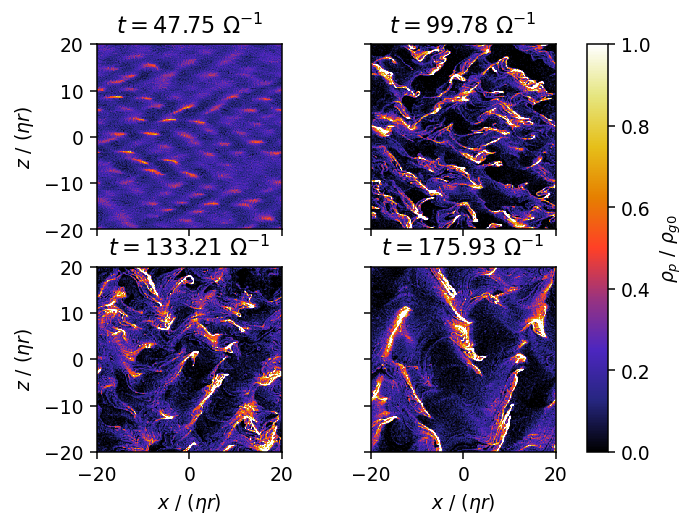

In [3]:
# Collect .athdf outputs, init sim constants and grid
run, vmin, vmax = 'BA', 0, 1
athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
outputs = sorted(list(Path('../nonlinear/%s/athdf'%run).glob(athinput["job"]["problem_id"]\
                                                         +'.out2.*.athdf')))
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
etar = 0.05                                # [H]
data = athena_read.athdf(outputs[0])
xf, zf = data['x1f']/etar, data['x2f']/etar

# Load data into memory
times, rhops = [], []
for output in outputs:
    data = athena_read.athdf(output)
    times.append(data['Time']*Omega)
    rhops.append(data['rhop'][0])          # [0]  flattens 3D array
    
# Plot
fig, axs = plt.subplots(2, 2, dpi=135)
for i,ax in enumerate(axs.flat):
    ax.set_aspect('equal')
    title = r'$t={:.2f}$ '.format(times[i]) + r'$\Omega^{-1}$'
    ax.set_title(title)
    img = ax.pcolormesh(xf, zf, rhops[i], vmin=vmin, vmax=vmax, cmap='CMRmap')
    ax.set(xlabel=r'$x$ / $(\eta r)$', ylabel=r'$z$ / $(\eta r)$')
    ax.label_outer()
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

Particle density snapshots for run BA with friction time $\tau_s = 1.0$ and a solids-to-gas ratio of $\epsilon = 0.2$.

**NOTE**—It takes slightly longer in our simulation time to reach snapshots most qualitatively similar to JY07.

## Fig. 3

Saturated state of runs BB and BC (both at time $t=16\,T$).

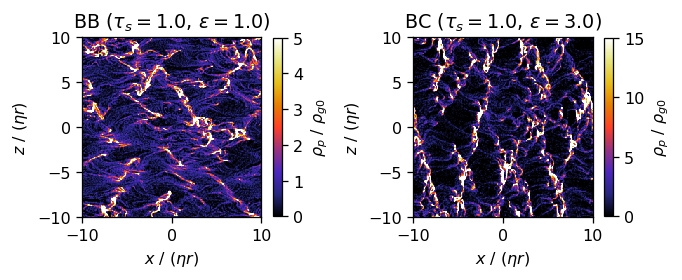

In [4]:
fig, axs = plt.subplots(1, 2, dpi=115)
runs = ['BB', 'BC']
vmins = [0, 0]
vmaxs = [5, 15]

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%runs[i])
    outputs = sorted(list(Path('../nonlinear/%s/athdf'%runs[i]).glob(athinput["job"]["problem_id"]\
                                                    +'.out2.*.athdf')))
    Omega = athinput['problem']['omega']       # local Keplerian angular frequency
    etar = 0.05                                # [H]
    epsilon = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
    tau_s = athinput['particles']['taus0']*Omega # dimensionless stopping time
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/etar, data['x2f']/etar
    # Plot
    ax.set_aspect('equal')
    ax.set_title(r'{:s} ($\tau_s={:.1f},\,\epsilon={:.1f}$)'.format(runs[i], tau_s, epsilon))
    img = ax.pcolormesh(xf, zf, data['rhop'][0], vmin=vmins[i], vmax=vmaxs[i], cmap='CMRmap')
    cb = fig.colorbar(img, ax=ax, shrink=0.42)
    cb.set_label(r'$\rho_p$ / $\rho_{g0}$')
    ax.set(xlabel=r'$x$ / $(\eta r)$', ylabel=r'$z$ / $(\eta r)$')
    ax.label_outer()
fig.tight_layout()

## Fig. 4

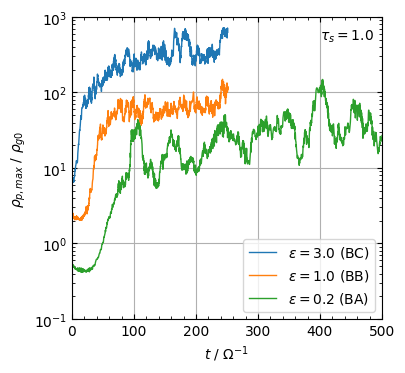

In [5]:
fig, ax = plt.subplots(figsize=(4,4), dpi=100)
runs = ['BC', 'BB', 'BA']

for run in runs:
    # Load simulation parameters and plot NAS results
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
    Omega = athinput['problem']['omega']
    epsilon = athinput['problem']['epsilon']
    label = r'$\epsilon={:.1f}$ ({:s})'.format(epsilon, run)
    data = np.loadtxt('../nonlinear/%s/plots/growth.txt'%run)
    times, rhopmax = data[:, 0]*Omega, data[:, 1]
    ax.semilogy(times, rhopmax, label=label, lw=1)
    
ax.set_ylabel(r'$\rho_{p,max}$ / $\rho_{g0}$')
ax.set_xlabel(r'$t$ / $\Omega^{-1}$')
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.text(400, 500, r'$\tau_s={:.1f}$'.format(tau_s))
ax.set(xlim=(0, 500), ylim=(0.1, 1000))
ax.legend()
ax.grid()

## Table 2
### Flow Properties

In [6]:
runs = ['AA', 'AB', 'AC', 'BA', 'BB', 'BC']
t_sats = [25, 2, 2, 15, 10, 20]                         # See each [run].ipynb
refs = [-0.138, -0.108, -0.035, -0.52, -0.341, -0.118]  # From JY07, Table 2
epsilons, tau_ss, avg_vp1s, ref_diffs = [], [], [], []

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
    tlim = athinput['time']['tlim']                     # time limit / T
    c_s = athinput['hydro']['iso_sound_speed']          # sound speed
    Np_tot = athinput['problem']['npx1']\
         *athinput['problem']['npx2']\
         *athinput['problem']['npx3']                   # total number of particles
    Omega = athinput['problem']['omega']                # local Keplerian ang. freq.
    epsilons.append(athinput['problem']['epsilon'])     # avg. BG dust/gas ρ-ratio
    Pi = athinput['problem']['duy0']                    # global rad. press. grad.
    tau_ss.append(athinput['particles']['taus0']*Omega) # dimensionless stopping time
    etav_K = Pi*c_s                                     # velocity (JY07)
    hst = athena_read.hst('../nonlinear/%s/SI.hst'%run)
    i_sat = hst['time'].size*t_sats[i]//tlim            # saturation output start
    avg_vp1s.append(np.average(hst['vp1'][i_sat:])/etav_K/Np_tot)
    ref_diffs.append(100*2*np.abs((avg_vp1s[i] - refs[i]) / (avg_vp1s[i] + refs[i])))

df = pd.DataFrame(
    {
        "Run": runs,
        r"$\tau_s$": tau_ss,
        r"$\epsilon$": epsilons,
        r"$\overline{v_x}$": avg_vp1s,
        "% diff": ref_diffs
    }
)
df.style.format({
    r"$\tau_s$": "{:.1f}",
    r"$\epsilon$": "{:.1f}",
    r"$\overline{v_x}$": "{:.3f}",
    "% diff": "{:.1f}"
})

,Run,$\tau_s$,$\epsilon$,$\overline{v_x}$,% diff
0,AA,0.1,0.2,-0.138,0.0
1,AB,0.1,1.0,-0.105,2.4
2,AC,0.1,3.0,-0.030,14.4
3,BA,1.0,0.2,-0.578,10.5
4,BB,1.0,1.0,-0.339,0.5
5,BC,1.0,3.0,-0.116,2.0


## Fig. 5

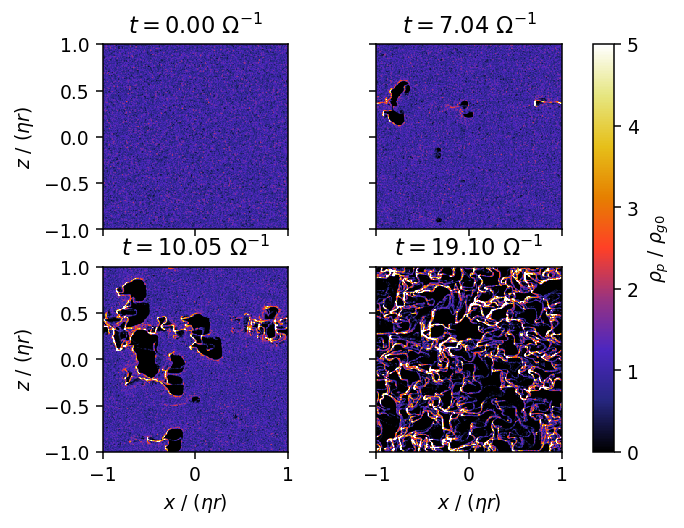

In [7]:
# Collect .athdf outputs, init sim constants and grid
run, vmin, vmax = 'AB', 0, 5
athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
outputs = sorted(list(Path('../nonlinear/%s/athdf'%run).glob(athinput["job"]["problem_id"]\
                                                         +'.out2.*.athdf')))
Omega = athinput['problem']['omega']       # local Keplerian angular frequency
etar = 0.05                                # [H]
data = athena_read.athdf(outputs[0])
xf, zf = data['x1f']/etar, data['x2f']/etar

# Load data into memory
times, rhops = [], []
for output in outputs:
    data = athena_read.athdf(output)
    times.append(data['Time']*Omega)
    rhops.append(data['rhop'][0])          # [0]  flattens 3D array
    
# Plot
fig, axs = plt.subplots(2, 2, dpi=135)
for i,ax in enumerate(axs.flat):
    ax.set_aspect('equal')
    title = r'$t={:.2f}$ '.format(times[i]) + r'$\Omega^{-1}$'
    ax.set_title(title)
    img = ax.pcolormesh(xf, zf, rhops[i], vmin=vmin, vmax=vmax, cmap='CMRmap')
    ax.set(xlabel=r'$x$ / $(\eta r)$', ylabel=r'$z$ / $(\eta r)$')
    ax.label_outer()
cb = fig.colorbar(img, ax=axs[:,:])
cb.set_label(r'$\rho_p$ / $\rho_{g0}$')

Onset of streaming turbulence for run AB ($\tau_s = 0.1$, $\epsilon = 1.0$).

**NOTE**—It takes slightly longer in our simulation time to reach snapshots most qualitatively similar to JY07.

## Fig. 7

AA: t = 1000 Ω⁻¹
AC: t = 50 Ω⁻¹


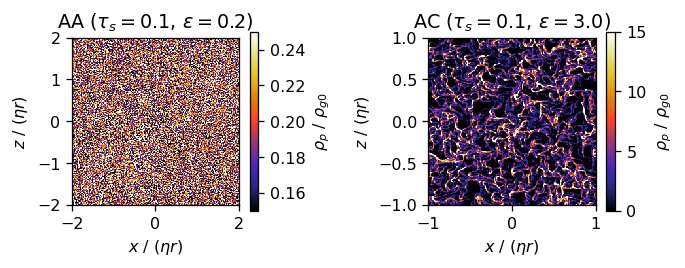

In [8]:
fig, axs = plt.subplots(1, 2, dpi=115)
runs = ['AA', 'AC']
vmins = [0.15, 0]
vmaxs = [0.25, 15]

for i,ax in enumerate(axs.flat):
    # Load run snapshot
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%runs[i])
    outputs = sorted(list(Path('../nonlinear/%s/athdf'%runs[i]).glob(athinput["job"]["problem_id"]\
                                                    +'.out2.*.athdf')))
    Omega = athinput['problem']['omega']         # local Keplerian angular frequency
    etar = 0.05                                  # [H]
    epsilon = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
    tau_s = athinput['particles']['taus0']*Omega # dimensionless stopping time
    data = athena_read.athdf(outputs[0])
    xf, zf = data['x1f']/etar, data['x2f']/etar
    # Plot
    ax.set_aspect('equal')
    ax.set_title(r'{:s} ($\tau_s={:.1f},\,\epsilon={:.1f}$)'.format(runs[i], tau_s, epsilon))
    img = ax.pcolormesh(xf, zf, data['rhop'][0], vmin=vmins[i], vmax=vmaxs[i], cmap='CMRmap')
    cb = fig.colorbar(img, ax=ax, shrink=0.42)
    cb.set_label(r'$\rho_p$ / $\rho_{g0}$')
    ax.set(xlabel=r'$x$ / $(\eta r)$', ylabel=r'$z$ / $(\eta r)$')
    ax.label_outer()
    print('{:s}: t = {:.0f}'.format(runs[i], data['Time']*Omega), 'Ω⁻¹')
fig.tight_layout()

Saturated states of run AA (at $t= 1000\,\Omega^{-1}$) and run AC (at $t= 50\,\Omega^{-1}$)

## Fig. 8

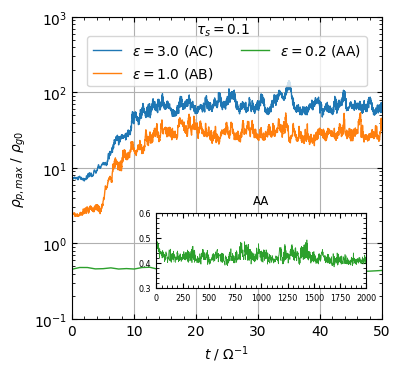

In [9]:
fig, ax = plt.subplots(figsize=(4,4), dpi=100)
axins = inset_axes(ax, width=2.1, height=.75, bbox_to_anchor=(.25, .08, .93, .2),
                   bbox_transform=ax.transAxes, loc=3)
runs = ['AC', 'AB', 'AA']

for run in runs:
    # Load simulation parameters and plot NAS results
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
    Omega = athinput['problem']['omega']
    epsilon = athinput['problem']['epsilon']
    label = r'$\epsilon={:.1f}$ ({:s})'.format(epsilon, run)
    data = np.loadtxt('../nonlinear/%s/plots/growth.txt'%run)
    times, rhopmax = data[:, 0]*Omega, data[:, 1]
    if run == 'AA':
        axins.set_title(run, fontsize='small')
        axins.plot(times, rhopmax, label=label, lw=0.5, color='tab:green')
        axins.set(xlim=(0, 2000), ylim=(0.30, 0.60))
        axins.minorticks_on()
        axins.tick_params(axis='both', which='both', top=True, right=True,
                          direction='in', labelsize='xx-small')
    ax.semilogy(times, rhopmax, label=label, lw=1)
    
ax.set_ylabel(r'$\rho_{p,max}$ / $\rho_{g0}$')
ax.set_xlabel(r'$t$ / $\Omega^{-1}$')
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.text(20, 600, r'$\tau_s={:.1f}$'.format(tau_s))
ax.set(xlim=(0, 50), ylim=(0.1, 1000))
ax.legend(loc=(0.05, 0.77), ncol=2)
ax.grid()

## Fig. 11

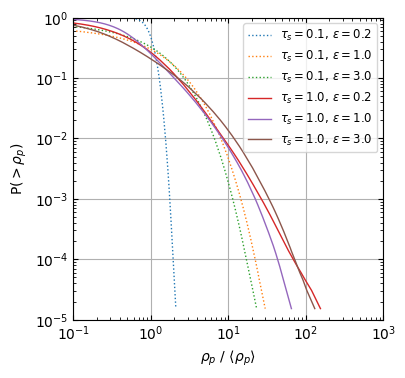

In [10]:
fig, ax = plt.subplots(figsize=(4,4), dpi=100)
runs = ['AA', 'AB', 'AC', 'BA', 'BB', 'BC']
lss = [':', ':', ':', '-', '-', '-',]

for i,run in enumerate(runs):
    athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
    Omega = athinput['problem']['omega']         # local Keplerian ang. freq.
    epsilon = athinput['problem']['epsilon']     # avg. BG dust/gas ρ-ratio
    tau_s = athinput['particles']['taus0']*Omega # dimensionless stopping time
    label = r'$\tau_s={:.1f},\,\epsilon={:.1f}$'.format(tau_s, epsilon)
    data = np.loadtxt('../nonlinear/%s/plots/cpdd_avg.txt'%run)
    cdf = data[:, 1]
    avg_rhops = data[:, 0]
    ax.loglog(avg_rhops, cdf, ls=lss[i], label=label, lw=1)
    
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(0.1, 1e3), ylim=(1e-5, 1), xlabel=r'$\rho_p$ / $\langle \rho_p \rangle$',
       ylabel=r'P$(>\rho_p)$')
ax.legend(fontsize='small')
ax.grid()

## Fig. 15

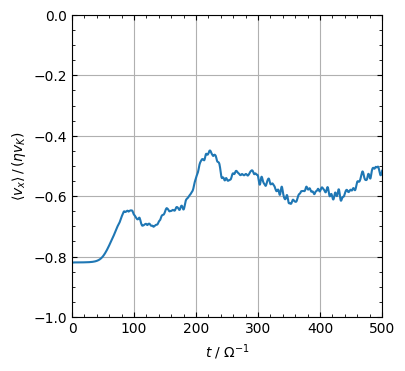

In [11]:
run = 'BA'
times, vp1s = [], []

athinput = athena_read.athinput('../nonlinear/%s/athinput.si'%run)
c_s = athinput['hydro']['iso_sound_speed']          # sound speed
Np_tot = athinput['problem']['npx1']\
     *athinput['problem']['npx2']\
     *athinput['problem']['npx3']                   # total number of particles
Omega = athinput['problem']['omega']                # local Keplerian ang. freq.
Pi = athinput['problem']['duy0']                    # global rad. press. grad.
etav_K = Pi*c_s                                     # velocity (JY07)
hst = athena_read.hst('../nonlinear/%s/SI.hst'%run)
times = hst['time']*Omega
vp1s = (hst['vp1'])/etav_K/Np_tot

fig, ax = plt.subplots(figsize=(4,4), dpi=100)
ax.plot(times, vp1s)
ax.minorticks_on()
ax.tick_params(axis='both', which='both', top=True, right=True, direction='in')
ax.set(xlim=(0, 500), ylim=(-1, 0), xlabel=r'$t$ / $\Omega^{-1}$',
       ylabel=r'$\langle v_x\rangle\,/\,(\eta v_K)$')
ax.grid()